# Project Overview
The objective of this project is to prepare a prototype of a machine learning model for [Zyfra](https://www.zyfra.com/), a company that develops efficiency solutions for heavy industry. 

The model should predict the amount of gold recovered from gold ore and therefore optimize production while elliminating unprofitable parameters.

## Ore Purification Process

<div align="center">
<img src="https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_ore_1591699963.jpg" alt="Gold Ore Purification Process" width="600" height="400">
</div>



#### Process Stages:
- **Rougher (floatation):** Gold ore mixture is fed into float banks to output rougher au (gold) concentrate and rougher tails (residual product with a low degress of valuable metals). This process is affected by the following rougher additions (reagents):
  - **Xanthate** - The floatation activator that allows mineral particles to attach to air bubbles within the floatation cells, therefore forming a froth layer that can be skimmed off.
  - **Sulphate** - A modifier in the floatation stage that regulates pH for optimtal levels of floatation.
  -  **Sodium Silicate** - A depressant that prevents unwanted gangue (waste rock) minerals from floating by make them more hydrophilic (more water absorbant/easily bonded to water).
- **Primary Cleaner:** The first purification stage following the rougher stage.
- **Secondary Cleaner:** The second purification stage following the first purification stage.
- **Final:** The final output of the process.

## Data Overview

The data is stored in three files:
- **gold_recovery_train.csv** — the training dataset 
- **gold_recovery_test.csv** — the test dataset 
- **gold_recovery_full.csv** — the source dataset 


We need to predict two values:
- the gold recovered after the rougher process (rougher.output.recovery)
- the gold recovered after the secondary cleaner process (final.output.recovery)

The model targets are the gold recovery calculation after the rougher and final cleaning stages. 


The features in the dataset are named using the following convention:<br/>
**[stage].[parameter_type].[parameter_name]**


*Possible values for [stage]:*
- **rougher** — flotation
- **primary_cleaner** — primary purification
- **secondary_cleaner** — secondary purification
- **final** — final characteristics

*Possible values for [parameter_type]:*
- **input** — raw material parameters
- **output** — product parameters
- **state** — parameters characterizing the current state of the stage
- **calculation** — calculation characteristics

Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.

Some parameters are not available because they were measured and/or calculated much later. As a result, some of the features in the training set aren't in the test set and the test set doesn't contain targets. However, the source dataset contrains both the training and test sets (including all the features) and can be merged on the index number.

It's possible that there are errors in the data since we are working with raw data downloaded from the warehouse.



## Project Process

1. Prepare the data.
 - Open the files and look into the data.
 - Check that the gold recovery calculation following the rougher stage is correct by finding the MAE (mean absolute error) between the given rougher.output.recovery feature value and manually calculating its value.
 - Determine which features aren't available in the test set.
 - Clean and preprocess the data.

2. Analyze the data.
 - Explore how the metal concentrations (Au, Ag (Silver), and Pb (Lead)) change after each purification stage.
 - Compare the feed particle size distributions between the training and test sets.
 - Analyze the total concentrations of all substances at the raw feed, rougher concentrate, and final concentrate stages.

 3. Build and evaluate the model.
 - Write a function to calculate the final SMAPE (symmetrical mean absolute percentage error).
 - Train different models and evaluate them using cross-validation. 
 - Test the best model (using the test sample).

# Prepare the Data
##### Import Needed Libraries and Datasets

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# read the data from the csv files and store them in dataframes
train = pd.read_csv('gold_recovery_train.csv', parse_dates=['date'])
test = pd.read_csv('gold_recovery_test.csv', parse_dates=['date'])
full = pd.read_csv('gold_recovery_full.csv', parse_dates=['date'])

In [3]:
# get information about the train dataframe
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                16860 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         16788 non-null  float64       
 2   final.output.concentrate_pb                         16788 non-null  float64       
 3   final.output.concentrate_sol                        16490 non-null  float64       
 4   final.output.concentrate_au                         16789 non-null  float64       
 5   final.output.recovery                               15339 non-null  float64       
 6   final.output.tail_ag                                16794 non-null  float64       
 7   final.output.tail_pb                                16677 non-null  float64       
 8   final.

Our data types are as expected. Beside the date feature, all features have missing values. Some have up to over 2,000 missing values.

In [4]:
display('Describe rougher variables:',train[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au','rougher.input.feed_size', 'rougher.input.feed_rate','rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol','rougher.input.floatbank10_sulfate','rougher.input.floatbank10_xanthate','rougher.input.floatbank11_sulfate','rougher.input.floatbank11_xanthate','rougher.output.tail_ag','rougher.output.tail_pb','rougher.output.tail_sol','rougher.state.floatbank10_a_air','rougher.state.floatbank10_a_level']].describe())

display("Describe rougher variables where rougher output concentrate au is 0:",train[train['rougher.output.concentrate_au'] == 0][['rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au','rougher.input.feed_size', 'rougher.input.feed_rate','rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol','rougher.input.floatbank10_sulfate','rougher.input.floatbank10_xanthate','rougher.input.floatbank11_sulfate','rougher.input.floatbank11_xanthate','rougher.output.tail_ag','rougher.output.tail_pb','rougher.output.tail_sol','rougher.state.floatbank10_a_air','rougher.state.floatbank10_a_level']].describe())

'Describe rougher variables:'

,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au,rougher.input.feed_size,rougher.input.feed_rate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level
count,16777.000000,16778.000000,14611.000000,16443.000000,16347.000000,16778.000000,16632.000000,16568.000000,15816.000000,16514.000000,16237.000000,14956.000000,14610.000000,16778.000000,14611.000000,16807.000000,16807.000000
mean,7.170717,17.401541,1.763930,58.676444,435.963431,7.832347,3.218931,32.636662,11.198142,5.366609,10.550080,5.792970,5.566579,0.596493,17.865309,1077.201302,-384.109359
std,3.002113,6.921875,0.731518,23.922591,156.592162,3.139014,1.477263,11.661981,3.964080,1.940766,4.560428,1.294180,1.045456,0.330819,3.455588,291.800894,112.408685
min,0.000000,0.000000,0.020676,9.659576,0.000044,0.000000,0.000000,0.000000,0.000002,0.000003,0.000049,0.000010,0.594562,0.000000,10.014648,-0.345168,-658.223080
25%,6.203083,17.443663,1.311610,47.575879,396.667936,6.889426,2.551143,32.170423,9.366078,4.802531,8.903492,5.097006,4.918713,0.413711,15.646980,999.636979,-499.908427
50%,7.443530,19.644663,1.747907,54.104257,488.629971,7.938193,3.297050,36.354079,11.179351,5.767015,11.001027,5.995942,5.718038,0.594959,17.996971,1001.310190,-300.233403
75%,8.965193,21.224486,2.190839,65.051064,540.548376,9.829857,4.181842,39.043343,13.203315,6.501621,13.004085,6.695277,6.308490,0.779544,19.933255,1299.577654,-299.976784
max,14.093363,28.522811,9.688980,484.967466,717.508837,14.869652,7.142594,48.363177,36.118275,31.493331,37.980648,9.698407,12.719177,3.778064,66.117188,1521.980372,-19.383282


'Describe rougher variables where rougher output concentrate au is 0:'

,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au,rougher.input.feed_size,rougher.input.feed_rate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level
count,1492.000000,1493.0,354.000000,1305.000000,1292.000000,1493.000000,1486.000000,1462.000000,903.000000,1293.000000,1275.000000,468.000000,354.000000,1493.000000,354.000000,1480.000000,1480.000000
mean,1.987817,0.0,1.964536,48.761784,128.927126,2.177404,0.901401,8.366416,5.851301,1.593812,3.851936,4.069056,5.881566,0.189015,16.638754,705.806119,-489.789418
std,3.674207,0.0,0.682643,31.642698,197.889458,3.997045,1.694939,15.463059,7.211947,2.393511,6.543244,2.188912,0.677961,0.359475,2.751443,598.853707,165.503175
min,0.000000,0.0,0.638096,14.523920,0.000044,0.000000,0.000000,0.000000,0.000050,0.000003,0.000094,0.000010,3.764520,0.000000,10.014648,-0.345168,-658.223080
25%,0.000000,0.0,1.656829,30.649600,0.160013,0.000000,0.000000,0.000000,0.009692,0.003627,0.018588,3.736192,5.416152,0.000000,14.644193,-0.004404,-650.118377
50%,0.000000,0.0,1.969209,45.224529,0.308362,0.000000,0.000000,0.000000,0.122985,0.007721,0.031003,4.301610,6.051283,0.000000,16.534157,999.129109,-501.030700
75%,0.205576,0.0,2.235973,48.979395,311.135911,0.265291,0.000000,0.000000,11.367277,4.000279,7.735872,5.704319,6.401932,0.373995,19.069426,1299.891653,-300.232459
max,12.559249,0.0,6.067395,339.310813,600.568146,13.850236,5.941000,44.740039,29.990941,9.517497,30.006327,9.514789,7.523648,2.799132,22.284018,1502.409462,-19.383282


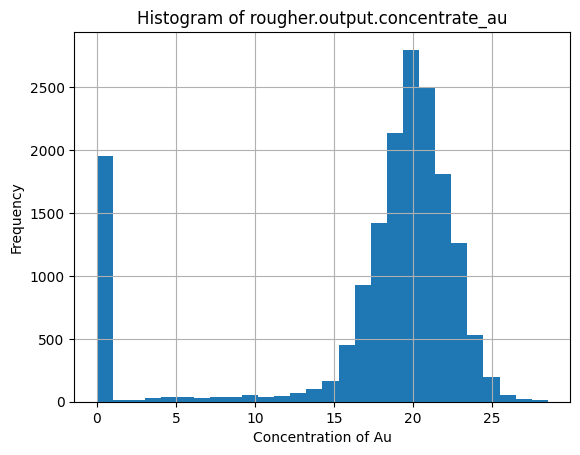

In [5]:
# plot a histogram of rougher.output.concentrate_au
train['rougher.output.concentrate_au'].hist(bins=28)
plt.title('Histogram of rougher.output.concentrate_au')
plt.xlabel('Concentration of Au')
plt.ylabel('Frequency')
plt.show()

There are 1,493 rows with a rougher output concentrate au of 0. This seems suspicious--maybe these zeroes are a placeholder for missing values, the data/measurements are erroneous, or no gold resulted from the rougher process.

#### Investigate possible explanations for rows with a rougher output concentrate au of 0.

In [6]:
# count rows in train where rougher.input.feed_au equals rougher.output.tail_au 
train[(train['rougher.input.feed_au'] == train['rougher.output.tail_au'])].shape[0]

0

There are no rows where the rougher input feed au and the rougher output tail au equal one another so this doesn't explain why the rougher output concentrate au can have a value of 0.

In [7]:
# count the number of rows in the training set where the rougher.output.concentrate_au is 0 and final.output.concentrate_au is > 0
print(train[(train['rougher.output.concentrate_au'] == 0) & (train['final.output.concentrate_au'] > 0)].shape[0])

# drop the inaccurate data from the training set
train = train.drop(train[(train['rougher.output.concentrate_au'] == 0) & (train['final.output.concentrate_au'] > 0)].index)


375


There are 375 rows of data where the final output concentrate of gold is greater than 0, yet the concentrate was 0 after the rougher stage. This can't be true, so this data is incorrect. We'll drop it from our training set.

In [8]:
# count the number of rows in the training set where the rougher.input.feed_au is 0 and rougher.output.concentrate_au is > 0
print(train[(train['rougher.input.feed_au'] == 0) & (train['rougher.output.concentrate_au'] > 0)].shape[0])

# drop the inaccurate data from the training set
train = train.drop(train[(train['rougher.input.feed_au'] == 0) & (train['rougher.output.concentrate_au'] > 0)].index)


44


It also doesn't make sense that the the rougher input feed au is 0, yet the rougher output concentrate au is greater than 0. There are 44 rows of data like this that we'll also drop.

In [9]:
# count the number of rows in the training set where the primary_cleaner.output.concentrate_au is 0 and final.output.concentrate_au is > 0
print(train[(train['primary_cleaner.output.concentrate_au'] == 0) & (train['final.output.concentrate_au'] > 0)].shape[0])

# drop the inaccurate data from the training set
train = train.drop(train[(train['primary_cleaner.output.concentrate_au'] == 0) & (train['final.output.concentrate_au'] > 0)].index)

102


There are 101 rows where the primary cleaner output concentrate au is 0 and the final output concentrate au is greater than 0. Once again, this data does not make sense so we will drop these rows from the training set too.

In [10]:
# count the number of rows where the final output recovery is 0 and the final output concentrate au is > 0
print(train[(train['final.output.recovery'] == 0) & (train['final.output.concentrate_au'] > 0)].shape[0])

0


In [11]:
# count the number of rows where the final output recovery is > 0 and the final output concentrate au is 0
print(train[(train['final.output.recovery'] > 0) & (train['final.output.concentrate_au'] == 0)].shape[0])

0


There are no rows where the values of final output recovery and final output concentrate au don't make sense together.

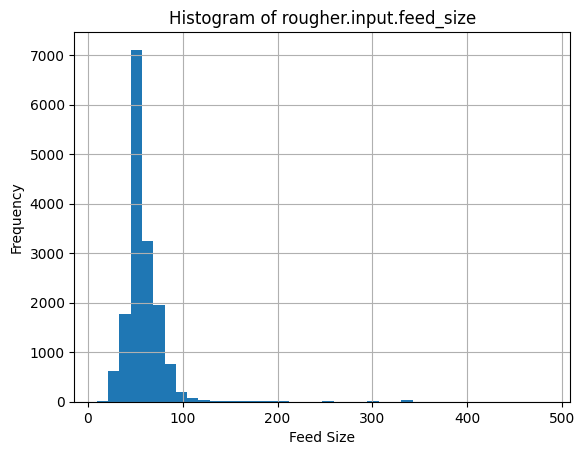

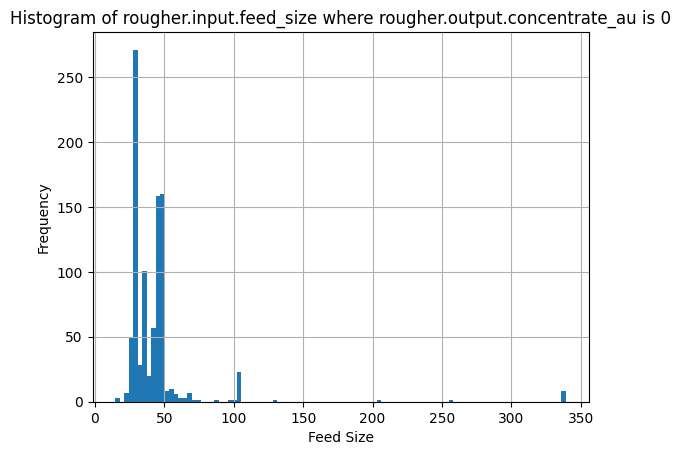

In [12]:
# plot the distribution of rougher.input_feed_size
train['rougher.input.feed_size'].hist(bins=40)
plt.title('Histogram of rougher.input.feed_size')
plt.xlabel('Feed Size')
plt.ylabel('Frequency')
plt.show()

# plot the distribution of rougher.input_feed_size where the rougher.output.concentrate_au is 0
train[train['rougher.output.concentrate_au'] == 0]['rougher.input.feed_size'].hist(bins=100)
plt.title('Histogram of rougher.input.feed_size where rougher.output.concentrate_au is 0')
plt.xlabel('Feed Size')
plt.ylabel('Frequency')
plt.show()

When the rougher output concentrate au is 0, the rougher input feed size is mostly about 25-50. Given that the mode of input feed size is about 50 for the training data set in general, this seems reasonable.

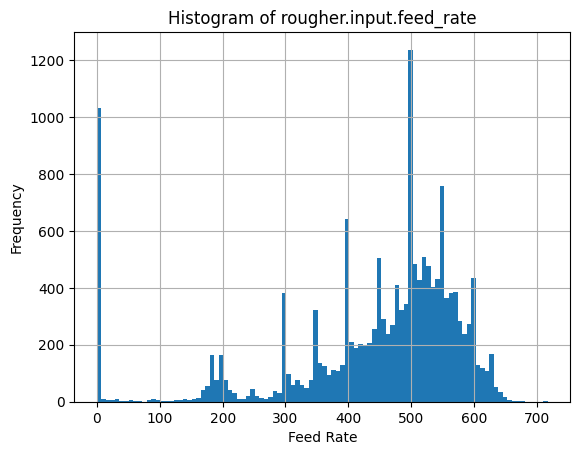

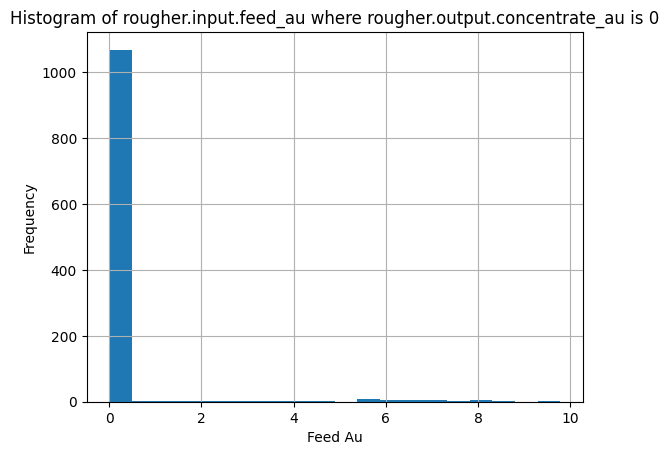

In [13]:
# plot the distribution of rougher.input_feed_rate 
train['rougher.input.feed_rate'].hist(bins=100)
plt.title('Histogram of rougher.input.feed_rate')
plt.xlabel('Feed Rate')
plt.ylabel('Frequency')
plt.show()

# plot the distribution of rougher.input_feed_au where the rougher.output.concentrate_au is 0
train[train['rougher.output.concentrate_au'] == 0]['rougher.input.feed_au'].hist(bins=20)
plt.title('Histogram of rougher.input.feed_au where rougher.output.concentrate_au is 0')
plt.xlabel('Feed Au')
plt.ylabel('Frequency')
plt.show()


When the rougher output concentrate au is 0, the input feed rate is almost always about 0. In comparison to the distribution of the input feed rate overall, these values definitely seem off. Perhaps the near-0 input feed rate is an error or placeholder for missing data as well.

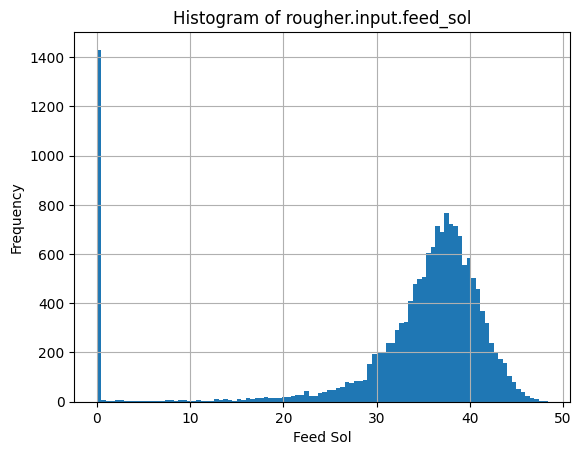

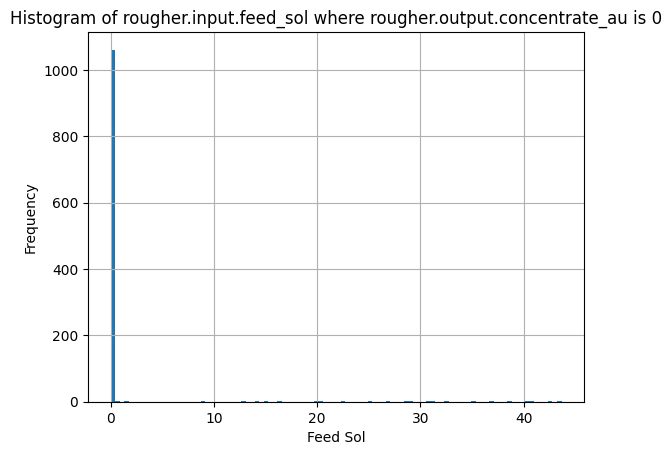

In [14]:
# plot the distribution of input.feed_sol
train['rougher.input.feed_sol'].hist(bins=100)
plt.title('Histogram of rougher.input.feed_sol')
plt.xlabel('Feed Sol')
plt.ylabel('Frequency')
plt.show()

# plot the distribution of input.feed_sol where the rougher.output.concentrate_au is 0
train[train['rougher.output.concentrate_au'] == 0]['rougher.input.feed_sol'].hist(bins=100)
plt.title('Histogram of rougher.input.feed_sol where rougher.output.concentrate_au is 0')
plt.xlabel('Feed Sol')
plt.ylabel('Frequency')
plt.show()

In [15]:
# count the rows where the input rougher concentrate au is 0 and the rougher output concentrate au is 0
train[(train['rougher.input.feed_au'] == 0) & (train['rougher.output.concentrate_au'] == 0)].shape[0]

1060

In [16]:
# replace values of 0 in the rougher.output.concentrate_au column with NaN
train['rougher.output.concentrate_au'] = train['rougher.output.concentrate_au'].replace(0, np.nan)

In [17]:
# drop all rows with NaN values for the rougher.output.concentrate_au, rougher.input.feed_au, and the rougher.output.tail_au columns
train = train.dropna(subset=['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery', 
                              'final.output.recovery', 'final.output.concentrate_au'])

It looks like there is a pattern that when rougher output concentrate au is 0, a high majority of each related column's values tend to be zero or near zero as well. It's fairly safe to say these rows are actually missing data or erroneous and we can drop them since they represent only about 6.3% of our original dataset size.

#### Confirm that the gold recovery calculation following the rougher stage is correct 

In [18]:
# define a function that calculates the recovery of gold
def gold_recovery(row):
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    denominator = F*(C-T)
    
    # check if the denominator is zero
    if denominator == 0:
        # return 0 if the denominator in the recovery formula is 0 
        return 0  # or return 0, or any other value that makes sense in your context
    
    return ((C*(F-T))/(denominator))*100

# apply the function to the train dataframe and store the result in a new column
train['rougher.output.recovery_calc'] = train.apply(gold_recovery, axis=1)


In [19]:
# calculate the mean absolute error between the calculated recovery and the actual recovery
mae = mean_absolute_error(train['rougher.output.recovery'], train['rougher.output.recovery_calc'])

# print the mean absolute error
print('Mean Absolute Error:', mae)

Mean Absolute Error: 9.420027279379386e-15


The mean absolute error of our rougher output recovery value (given vs. calculated) is extremely low; therefore, we can be confident in the accuracy of the provided rougher output recovery feature.

#### Get the missing target values for the testing set from the source data

In [20]:
# get the missing target values from the full dataframe (along with the other missing features) and merge them with the test dataframe
test = test.merge(full[['rougher.output.recovery', 'final.output.recovery']], left_index=True, right_index=True)


#### Explore which features aren't in the testing set that are in the training set

In [21]:
# get the columns in each dataframe
columns_full = set(full.columns)
columns_test = set(test.columns)

# find columns in the full dataframe that are not in the test dataframe
columns_not_in_test = columns_full - columns_test

# print the columns that are not in the test dataframe
print("Columns not in the test dataset:")
columns_not_in_test = sorted(columns_not_in_test)
for c in columns_not_in_test:
    print(c)



Columns not in the test dataset:
final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_au
secondary_cleaner.output.tail_p

The features not available in the test data set are mostly output and calculation parameter. Their parameters names are concentrations of au, pb, sol, and ag, the product residues (tails) of ag, au, pb, and sol, and the recovery of au after each stage.

#### Check for and process erroneous data in the testing set (mirroring what was done to the training set)

In [22]:
# merge missing columns from the full dataframe with the test dataframe
test_full = test.merge(full[columns_not_in_test], left_index=True, right_index=True)

In [23]:
# count rows in test where rougher.input.feed_au equals rougher.output.tail_au 
test_full[(test_full['rougher.input.feed_au'] == test_full['rougher.output.tail_au'])].shape[0]

0

There are no rows where the rougher input feed au and the rougher output tail au equal one another so this doesn't explain why the rougher output concentrate au can have a value of 0.

In [24]:
# count the number of rows in the testing set where the rougher.output.concentrate_au is 0 and final.output.concentrate_au is > 0
print(test_full[(test_full['rougher.output.concentrate_au'] == 0) & (test_full['final.output.concentrate_au'] > 0)].shape[0])

# drop the inaccurate data from the testing set
test = test.drop(test_full[(test_full['rougher.output.concentrate_au'] == 0) & (test_full['final.output.concentrate_au'] > 0)].index)

109


There are 109 rows of data where the final output concentrate of gold is greater than 0, yet the concentrate was 0 after the rougher stage. This can't be true, so this data is incorrect. We'll drop it from our testing set.

In [25]:
# count the number of rows in the testing set where the rougher.input.feed_au is 0 and rougher.output.concentrate_au is > 0
print(test_full[(test_full['rougher.input.feed_au'] == 0) & (test_full['rougher.output.concentrate_au'] > 0)].shape[0])

# drop the inaccurate data from the testing set
test = test.drop(test_full[(test_full['rougher.input.feed_au'] == 0) & (test_full['rougher.output.concentrate_au'] > 0)].index)

335


It also doesn't make sense that the the rougher input feed au is 0, yet the rougher output concentrate au is greater than 0. There are 335 rows of data like this that we'll also drop.

In [26]:
# get the rows where the rougher.output.concentrate_au is 0 in test_full
zero_rougher_output_concentrate_au = test_full[test_full['rougher.output.concentrate_au'] == 0]

# see if test.index exists in zero_rougher_output_concentrate_au.index and drop the rows that exist
test = test.drop(test[test.index.isin(zero_rougher_output_concentrate_au.index)].index)


In [27]:
# get all rows with NaN values for the rougher.output.concentrate_au, rougher.input.feed_au, and the rougher.output.tail_au columns in test_full
nan_au_rows = test_full[test_full['rougher.output.concentrate_au'].isna() | test_full['rougher.input.feed_au'].isna() | test_full['rougher.output.tail_au'].isna() | test_full['rougher.output.recovery'].isna()]

# drop rows in nan_au_rows from test 
test = test.drop(test[test.index.isin(nan_au_rows.index)].index)


#### Check for duplicate rows in the train and test datasets

In [28]:
# check for duplicates in the train and test dataframes
print(f"Duplicates in training set: {train.duplicated().sum()}")
print(f"Duplicates in testing set: {test.duplicated().sum()}")

Duplicates in training set: 0
Duplicates in testing set: 0


#### Examine how the concentration of the metals change depending on the purification stage

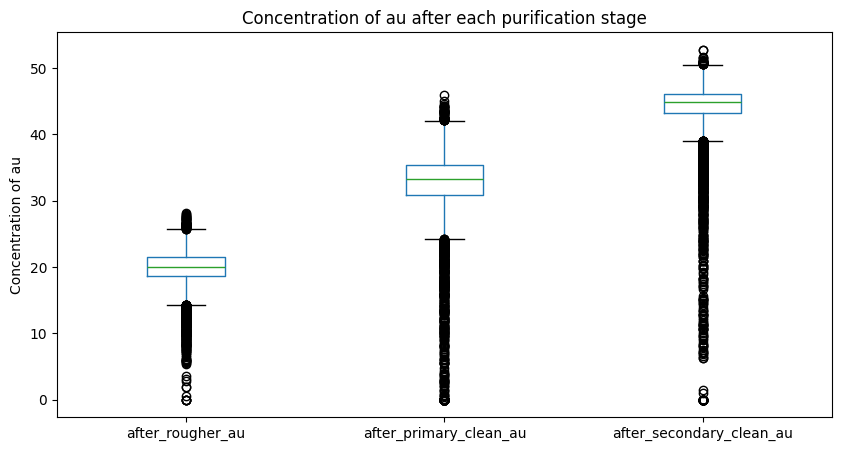

% change in au concentrate after primary purification: 63.77
% change in au concentrate after secondary purification: 35.28



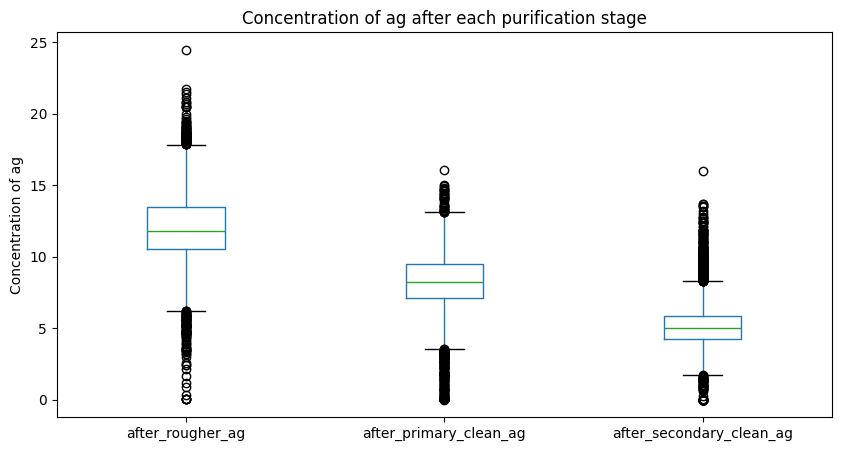

% change in ag concentrate after primary purification: -31.52
% change in ag concentrate after secondary purification: -37.59



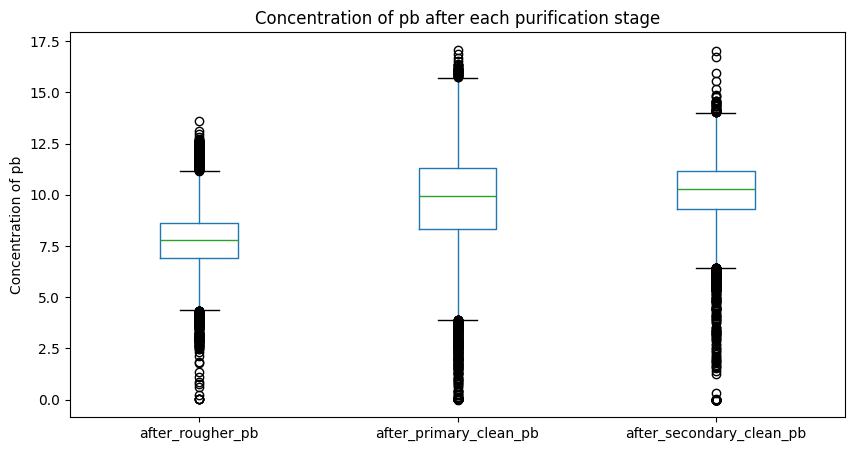

% change in pb concentrate after primary purification: 22.13
% change in pb concentrate after secondary purification: 6.0



In [29]:
'''
take note of how the concentration of the metals change depending on the purification stage
'''

# create a list of the metals
metals = ['au', 'ag', 'pb']

# create an empty dataframe to store the concentration of the metals after each purification stage in
df = pd.DataFrame()

# iterate through the metals, create a boxplot of the concentration of the metals after each purification stage, and summarize the percentage change after each stage
for i in metals:
    df['after_rougher_' + i] = train['rougher.output.concentrate_' + i]
    df['after_primary_clean_' + i] = train['primary_cleaner.output.concentrate_' + i]
    df['after_secondary_clean_' + i] = train['final.output.concentrate_' + i]
    df.boxplot(column=['after_rougher_' + i, 'after_primary_clean_' + i, 'after_secondary_clean_' + i] # specify the columns to plot
               , figsize=(10, 5) # specify the size of the plot
                , grid=False) # remove the grid
    plt.title(f'Concentration of {i} after each purification stage') # add a title to the plot
    plt.ylabel(f'Concentration of {i}') # add a label to the y-axis
    plt.show() # display the plot
    print(f"% change in {i} concentrate after primary purification: {round(((df['after_primary_clean_' + i].sum() - df['after_rougher_' + i].sum())/df['after_rougher_' + i].sum())*100,2)}") # print the percentage change in the concentration of the metal after the primary purification stage
    print(f"% change in {i} concentrate after secondary purification: {round(((df['after_secondary_clean_' + i].sum() - df['after_primary_clean_' + i].sum())/df['after_primary_clean_' + i].sum())*100,2)}\n") # print the percentage change in the concentration of the metal after the secondary purification stage


On average, the concentration of gold increases 63.8% after the primary purification step and then increases another 35.3% after the secondary purification step.

Meanwhile, the silver (ag) concentration decreases 31.5% and 37.6%, on average, after the primary and secondary purification stages, respectively.

The concentration of lead (pb) actually increases 22.1% after the primary purificationo stage and then increases just 6% more after the secondary purification step.

#### Compare the feed particle size distributions between the training and test sets

Describe the training set rougher input feed size feature:
 count    13639.000000
mean        60.174517
std         22.513025
min          9.659576
25%         49.016018
50%         55.460450
75%         66.102470
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Describe the testing set rougher input feed size feature:
 count    4578.000000
mean       57.480086
std        23.307785
min         0.046369
25%        43.953860
50%        53.062286
75%        63.729337
max       477.445473
Name: rougher.input.feed_size, dtype: float64


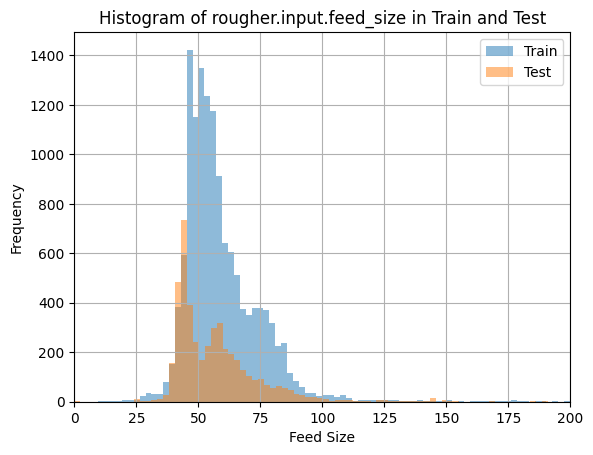

In [30]:
print(f"Describe the training set rougher input feed size feature:\n {train['rougher.input.feed_size'].describe()}")
print(f"\nDescribe the testing set rougher input feed size feature:\n {test['rougher.input.feed_size'].describe()}")


# plot the distribution of the rougher.input.feed_size in the train and test dataframes
train['rougher.input.feed_size'].hist(bins=200, alpha=0.5, label='Train')
test['rougher.input.feed_size'].hist(bins=200, alpha=0.5, label='Test')
plt.title('Histogram of rougher.input.feed_size in Train and Test')
plt.xlim(0, 200)
plt.xlabel('Feed Size')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The feed particle size distributions between the training and testing sets are similar. They have a similar distribution skew, mean, median, and max value.

#### Plot the distribution of all substances at the raw feed, rougher concentrate, and final concentrate stages of the process

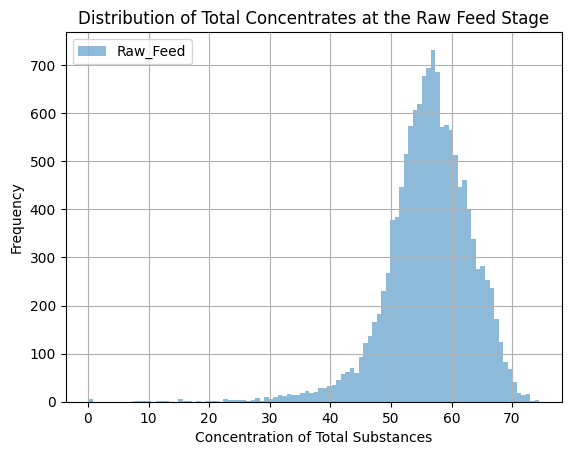

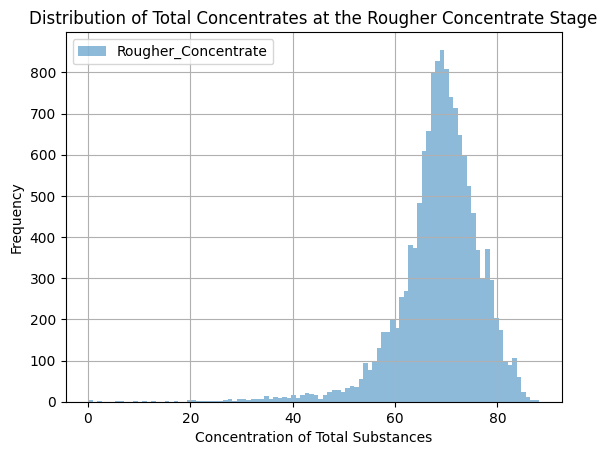

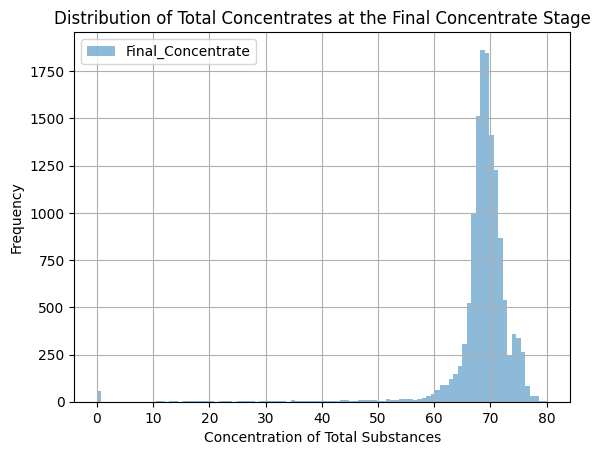

In [31]:
# plot the distribution of all substances at the raw feed, rougher concentrate, and final concentrate stages of the process
substances = ['au', 'ag', 'pb', 'sol']

# create an empty dataframe to store the total concentration of the substances at each stage
total_concentrate = pd.DataFrame()

# add all the substances together at each stage of the process
total_concentrate['Raw_Feed'] = train['rougher.input.feed_au'] + train['rougher.input.feed_ag'] + train['rougher.input.feed_pb'] + train['rougher.input.feed_sol']
total_concentrate['Rougher_Concentrate'] = train['rougher.output.concentrate_au'] + train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_pb'] + train['rougher.output.concentrate_sol']
total_concentrate['Final_Concentrate'] = train['final.output.concentrate_au'] + train['final.output.concentrate_ag'] + train['final.output.concentrate_pb'] + train['final.output.concentrate_sol']

# create a list of the stages to iterate through
stages = ['Raw_Feed', 'Rougher_Concentrate', 'Final_Concentrate']

# iterate through the stages and plot the histogram of the total concentrate at each stage
for i in stages:
    total_concentrate[i].hist(bins=100, alpha=0.5, label=i) # plot the histogram of the summed concentrate at each stage
    plt.title(f'Distribution of Total Concentrates at the {i.replace('_',' ')} Stage') # add a title to the plot
    plt.xlabel(f'Concentration of Total Substances') # add a label to the x-axis
    plt.ylabel('Frequency') # add a label to the y-axis 
    plt.legend() # add a legend to the plot
    plt.show() # display the plot

#### The mode of total concentrate increases after the raw feed stage. The mode of total concentrate is similar between the rougher and final stages (around 70), yet the dispersion of total concentrate narrows significantly; there are over double the number of instances where the total concentrate is around 70 in the final stage compared to the rougher stage.

There are a small number of samples where the concentrate of each substance is 0 within a stage. Next, we'll take a closer look at those to see if the data is erroneous or not. If it is, we'll remove those values from the training and testing sets to protect our model from bad data.

In [32]:
# store values where the final output concentrate of all substances is 0 and display all columns
zero_final_output = train[(train['final.output.concentrate_au'] == 0) & (train['final.output.concentrate_ag'] == 0) & (train['final.output.concentrate_pb'] == 0) & (train['final.output.concentrate_sol'] == 0)]

# compare the the values of au, ag, pb, and sol throughout the process where the final output of all concentrations is 0
print(zero_final_output[['final.output.recovery', 'final.output.concentrate_au', 'secondary_cleaner.output.tail_au', 'primary_cleaner.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'final.output.concentrate_ag', 'secondary_cleaner.output.tail_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_pb', 'secondary_cleaner.output.tail_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_sol', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.concentrate_sol']])

       final.output.recovery  final.output.concentrate_au  \
707                      0.0                          0.0   
1354                     0.0                          0.0   
1355                     0.0                          0.0   
1356                     0.0                          0.0   
1357                     0.0                          0.0   
2592                     0.0                          0.0   
2593                     0.0                          0.0   
2810                     0.0                          0.0   
4157                     0.0                          0.0   
4158                     0.0                          0.0   
4159                     0.0                          0.0   
4161                     0.0                          0.0   
4165                     0.0                          0.0   
5037                     0.0                          0.0   
5136                     0.0                          0.0   
5397                    

These values largely don't make logical sense so we'll drop them from the training set and infer values to drop in the testing set that would represent a final total concentrate of 0.

In [33]:
# drop values from the training set where the final output concentrate of all substances is 0
train = train.drop(zero_final_output.index)

In [34]:
# get the rows in the testing set where the final output concentrate of all substances is 0
zero_final_output_test = test_full[(test_full['final.output.concentrate_au'] == 0) & (test_full['final.output.concentrate_ag'] == 0) & (test_full['final.output.concentrate_pb'] == 0) & (test_full['final.output.concentrate_sol'] == 0)]

# drop the rows from the testing set where the final output concentrate of all substances is 0 and the index exists in the test dataframe
test = test.drop(test[test.index.isin(zero_final_output_test.index)].index)



#### Fill in the remaining missing values in the training and testing sets

In [35]:
# sort the training set by date
train = train.sort_values('date')

# fill the remaining missing values using the forward fill method
train = train.ffill()

# sort the testing set by date
test = test.sort_values('date')

# fill the remaining missing values using the forward fill method
test = test.ffill()

We can fill the remaining missing values in the training and testing sets using the forward fill method which will fill missing values of our features based on the value from the previous row. We know values are similar based on date of the extraction so once we sort our dataframe by date, the forward fill method is a reliable way to fill in these missing values since we have already cleaned up erroneous and placeholder values in both our training and testing datasets.

# Build the Model

#### Remove Features That Don't Exist in the Testing Set from the Training Set

In [36]:
# drop columns that aren't in the test set from the training set
train_aligned = train.drop(columns=columns_not_in_test)

print(train_aligned.columns)

# drop the date feature from the training set
train_aligned = train_aligned.drop(columns=['date','rougher.output.recovery_calc'], axis=1)


Index(['date', 'final.output.recovery', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.output.recovery',
       'rougher.state.floatbank10_

We can only use the features that exist in the production (test) dataset to train our model with so we can drop columns that don't exist in the testing set from our training set features.

### Remove Outliers

In [37]:
# salculate IQR-based outlier bounds on the training set
def calculate_iqr_bounds(df):
    bounds = {}
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        bounds[column] = (lower_bound, upper_bound)
    return bounds

# apply outlier bounds to filter rows
def remove_outliers(df, bounds):
    for column, (lower_bound, upper_bound) in bounds.items():
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# calculate IQR bounds from the training set
iqr_bounds = calculate_iqr_bounds(train_aligned)

# remove outliers from training set
train = remove_outliers(train_aligned, iqr_bounds)

# remove outliers from test set based on training set IQR bounds
test = remove_outliers(test, iqr_bounds)


#### Specify the features and target for the training and testing sets

In [38]:
# set the train target to the rougher output recovery and final output recovery columns
train_target = train[['rougher.output.recovery','final.output.recovery']]

# drop the targets from train_features
train_features = train.drop(columns=['rougher.output.recovery','final.output.recovery'], axis=1)

# set the target to the final output recovery column and the features to the remaining columns
test_target = test[['rougher.output.recovery','final.output.recovery']]
test_features = test.drop(columns=['rougher.output.recovery','final.output.recovery','date'], axis=1)


#### Scale the features

In [39]:
# specify the numeric features
features_numeric = list(test_features.columns)

# initialize the standard scaler
scaler = StandardScaler()

# fit and transform the training and testing features using the standard scaler
train_features_scaled = scaler.fit_transform(train_features[features_numeric])
test_features_scaled = scaler.fit_transform(test_features[features_numeric])

# convert the scaled features to dataframes
train_features_scaled = pd.DataFrame(train_features_scaled, columns=features_numeric)
test_features_scaled = pd.DataFrame(test_features_scaled, columns=features_numeric)

# check the shape of the scaled features
print(train_features_scaled.shape)
print(test_features_scaled.shape)

(3110, 52)
(1088, 52)


The testing set represents ~25% of the total rows in the training and testing set added together. This is an good relative ratio of data between our training and testing sets. 

#### Create a function to calculate the SMAPE

In [40]:
# define a function to calculate the symmetric mean absolute percentage error (smape)
def smape(target, prediction):
    return 100/len(target) * np.sum(2 * np.abs(prediction - target) / (np.abs(target) + np.abs(prediction)))


The symmetric mean absolute percentage error (smape) is an accuracy measure based on percentage errors. It normalizes the absolute error by taking the absolute difference between the actual and predicted values' averages. It is symmetric because it is always non-negative and does change depending on whether the predicted values are lower or higher than the actual ones, and is hence scaled by the same factor regardless of the error direction.

SMAPE can take values of 0% to 200% where 0% represents a perfect prediction capability and 200% represents the worst prediction capability. A score of 100% is also a relatively poor reflection of model performance--it means, on average, the predictions are just as far from the actual values as the actual values are from zero.

#### Build a Linear Regression Model

In [44]:
# initialize model constructor
lr_model = LinearRegression() 

# define the smape scorer
smape_scorer = make_scorer(smape, greater_is_better=False)

# initialize the scores dictionary
scores = {}
positive_scores = {}

# calculate the cross validation scores for the linear regression model
for target_column in ['rougher.output.recovery', 'final.output.recovery']:
    scores[target_column] = cross_val_score(lr_model, train_features_scaled, train_target[target_column], cv=5, scoring=smape_scorer)
    positive_scores[target_column] = -scores[target_column]

# calculate and print the final smape score
final_score = (positive_scores['rougher.output.recovery'].mean() * 0.25) + (positive_scores['final.output.recovery'].mean() * 0.75)
print('Cross Validation Linear Regression Final Weighted SMAPE Score:', final_score)

Cross Validation Linear Regression Final Weighted SMAPE Score: 8.29152254205303


#### Build a Decision Tree Regressor Model

In [45]:
# choose hyperparameter range
depth_range = range(1, 15)  

# loop through the hyperparameter range and calculate the final smape score for each depth
for depth in depth_range:
    # initialize model constructor
    dt_model = DecisionTreeRegressor(max_depth=depth, random_state=12345) 
    
    # initialize the scores dictionary
    scores = {}
    positive_scores = {}
    
    # calculate the cross validation scores for the decision tree model
    for target_column in ['rougher.output.recovery', 'final.output.recovery']:
        scores[target_column] = cross_val_score(dt_model, train_features_scaled, train_target[target_column], cv=5, scoring=smape_scorer)
        positive_scores[target_column] = -scores[target_column]
    
    # calculate and print the final smape score
    final_score = (positive_scores['rougher.output.recovery'].mean() * 0.25) + (positive_scores['final.output.recovery'].mean() * 0.75)
    print(f'Cross-validation Decision Tree Regressor Final Weighted SMAPE Score with depth {depth}:', final_score)

Cross-validation Decision Tree Regressor Final Weighted SMAPE Score with depth 1: 7.1320316269592325
Cross-validation Decision Tree Regressor Final Weighted SMAPE Score with depth 2: 6.665816911421026
Cross-validation Decision Tree Regressor Final Weighted SMAPE Score with depth 3: 7.1193157406433
Cross-validation Decision Tree Regressor Final Weighted SMAPE Score with depth 4: 7.24492824495611
Cross-validation Decision Tree Regressor Final Weighted SMAPE Score with depth 5: 7.974643574395582
Cross-validation Decision Tree Regressor Final Weighted SMAPE Score with depth 6: 8.142522202826884
Cross-validation Decision Tree Regressor Final Weighted SMAPE Score with depth 7: 8.04701393203293
Cross-validation Decision Tree Regressor Final Weighted SMAPE Score with depth 8: 8.572068048373435
Cross-validation Decision Tree Regressor Final Weighted SMAPE Score with depth 9: 8.892145247221293
Cross-validation Decision Tree Regressor Final Weighted SMAPE Score with depth 10: 9.004426610244883
Cr

#### Build a Random Forest Regressor Model

In [46]:
# loop through the hyperparameter range
for est in [30, 50, 100]:
    for depth in range (1, 10):
        # initialize model constructor
        rf_model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        
        # initialize the scores dictionary
        scores = {}
        positive_scores = {}

        # specify the target colums to loop through
        target_columns = ['rougher.output.recovery', 'final.output.recovery']

        # loop through each target column and calculate the scores
        for target_column in target_columns:
            scores[target_column] = cross_val_score(rf_model, train_features_scaled, train_target[target_column], cv=5, scoring=smape_scorer)
            positive_scores[target_column] = -scores[target_column]
        
        # calculate and print the final weighted smape score for each depth and n_estimators combination
        final_score = (positive_scores['rougher.output.recovery'].mean() * 0.25) + (positive_scores['final.output.recovery'].mean() * 0.75)
        print(f'Cross-validation Random Forest Regressor Final Weighted SMAPE Score with depth {depth} and {est} n_estimators:', final_score)


Cross-validation Random Forest Regressor Final Weighted SMAPE Score with depth 1 and 30 n_estimators: 7.042248056677602
Cross-validation Random Forest Regressor Final Weighted SMAPE Score with depth 2 and 30 n_estimators: 6.477902383396611
Cross-validation Random Forest Regressor Final Weighted SMAPE Score with depth 3 and 30 n_estimators: 6.497134165546894
Cross-validation Random Forest Regressor Final Weighted SMAPE Score with depth 4 and 30 n_estimators: 6.404064173114712
Cross-validation Random Forest Regressor Final Weighted SMAPE Score with depth 5 and 30 n_estimators: 6.414025513021418
Cross-validation Random Forest Regressor Final Weighted SMAPE Score with depth 6 and 30 n_estimators: 6.387695518535898
Cross-validation Random Forest Regressor Final Weighted SMAPE Score with depth 7 and 30 n_estimators: 6.343958991820569
Cross-validation Random Forest Regressor Final Weighted SMAPE Score with depth 8 and 30 n_estimators: 6.336267683337242
Cross-validation Random Forest Regressor

#### Test the Best Model with the Test Set

In [47]:
# initialize the smape scores dictionary
smape_values = {}

# specify the target columns to loop through
for target_column in target_columns:

    # initialize the random forest regressor model
    rf_model = RandomForestRegressor(random_state=12345, n_estimators=30, max_depth=8)

    # fit the model to the training features and target
    rf_model.fit(train_features_scaled, train_target[target_column])

    # calculate the smape score for the target column
    smape_values[target_column] = smape(test_target[target_column], rf_model.predict(test_features_scaled))
    
# calculate the final weighted smape score and print it
final_score = (smape_values['rougher.output.recovery'].mean() * 0.25) + (smape_values['final.output.recovery'].mean() * 0.75)
print(f'Testing Set Random Forest Regressor Final Weighted SMAPE Score: {final_score}')

Testing Set Random Forest Regressor Final Weighted SMAPE Score: 9.342322333687115


#### Apply a Common Sense Check on the Model's Performance (Baseline Comparison with Mean Prediction)

##### Training Set Baseline Model

In [52]:
# initialize the smape scores and predictions dictionary
smape_values = {}
predictions = {}

# specify the target columns to loop through
for target_column in target_columns:
    # create a series of the training set median values of the target column with the same index as the training set
    predictions[target_column] = pd.Series(train_target[target_column].median(), index=train_target.index)

    # calculate the smape score for the target column and the median-based predictions
    smape_values[target_column] = smape(train_target[target_column], predictions[target_column])
    
# calculate the final weighted smape score and print it
final_score = (smape_values['rougher.output.recovery'].mean() * 0.25) + (smape_values['final.output.recovery'].mean() * 0.75)
print(f'Random Forest Regressor Final SMAPE Score for the Sanity Check: {final_score}')


Random Forest Regressor Final SMAPE Score for the Sanity Check: 7.540372929061904


Our best model is the random forest regressor model with a max_depth hyperparameter value of 8 and a n_estimator hyperparameter value of 30.

This model achieved a final weighted smape score of 6.33% for the training set (through cross-validation), which performed better than the constant or baseline model's score of 7.54% for the training set; we can confirm that our best performing model passes the performance common sense check.

##### Testing Set Baseline Model

In [50]:
# initialize the smape scores and predictions dictionary
smape_values = {}
predictions = {}

# specify the target columns to loop through
for target_column in target_columns:
    # create a series of the training set median values of the target column with the same index as the test set
    predictions[target_column] = pd.Series(train_target[target_column].median(), index=test_target.index)

    # calculate the smape score for the target column and the median-based predictions
    smape_values[target_column] = smape(test_target[target_column], predictions[target_column])
    
# calculate the final weighted smape score and print it
final_score = (smape_values['rougher.output.recovery'].mean() * 0.25) + (smape_values['final.output.recovery'].mean() * 0.75)
print(f'Random Forest Regressor Final SMAPE Score for the Sanity Check: {final_score}')


Random Forest Regressor Final SMAPE Score for the Sanity Check: 9.939339966616599


We can also confirm that our best model performs better better on the testing set than our baseline model does.

Our model's predictions achieved a final smape score of 9.34 while the constant value model (our sanity check) produced a final smape score of 9.93 and therefore also passes the performance common sense check.

# Project Conclusion

The Random Forest Regressor model resulted in the best final SMAPE score based on our training set (cross-validated) data. After testing it on the test set, we achieved a final SMAPE score (25% of the SMAPE score of the rougher.output.recovery target and 75% of the SMAPE score of the final.output.recovery target) of 9.93%. We also confirmed that our final model performs better than a simple constant or baseline model for both the training and testing sets.

Our final SMAPE score reflects a model that has a relatively low average error relative to the actual values, which indicates good predictive accuracy. It also indicates that the model's errors are reasonably balanced between underestimating and overestimating. Moving forward, Zyfra can leverage our machine learning model to optimize its gold extraction process and therefore optimize its profits through more efficient extraction and the elimination of unprofitable/costly process parameters.